## Binary Classificaiton

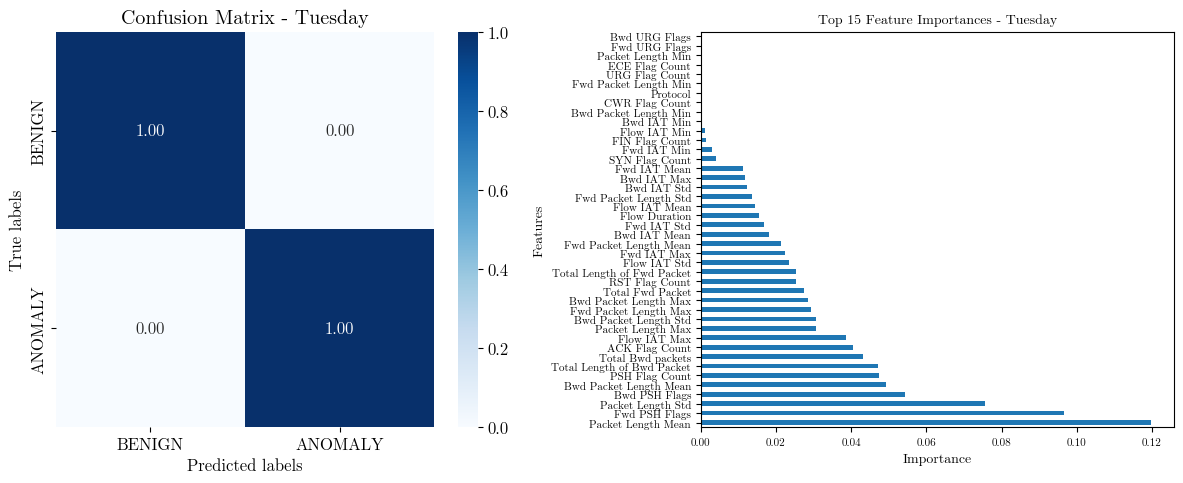

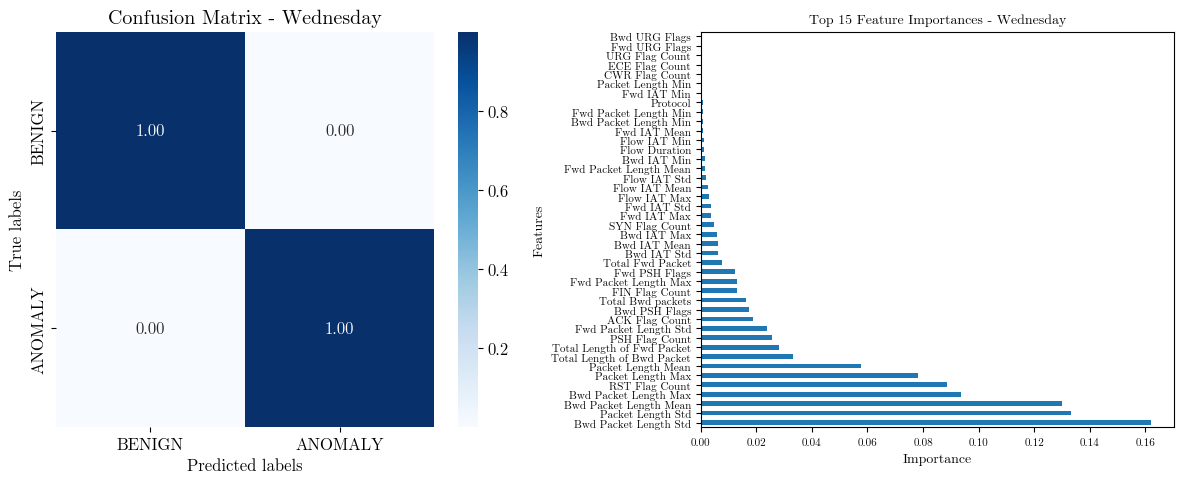

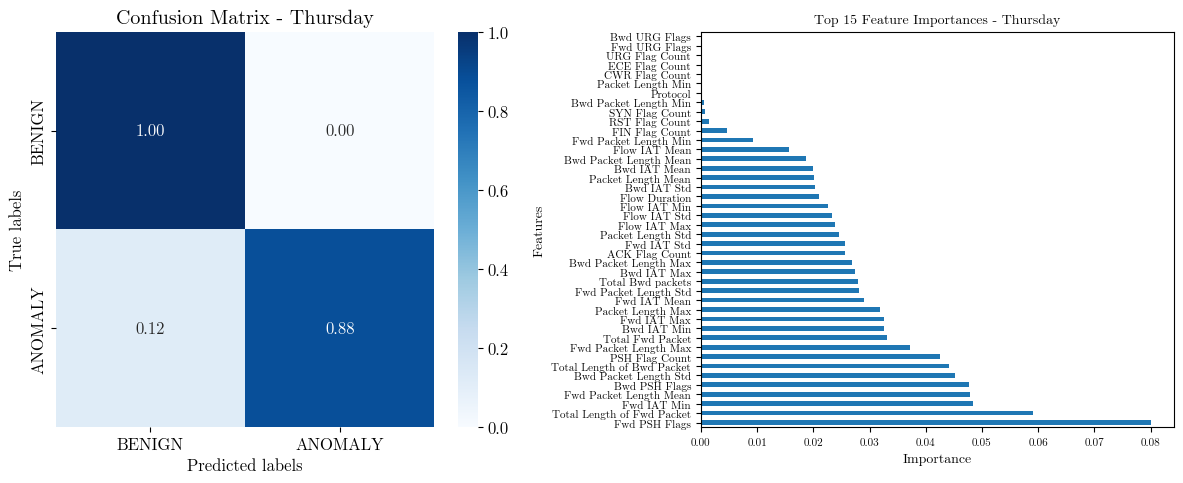

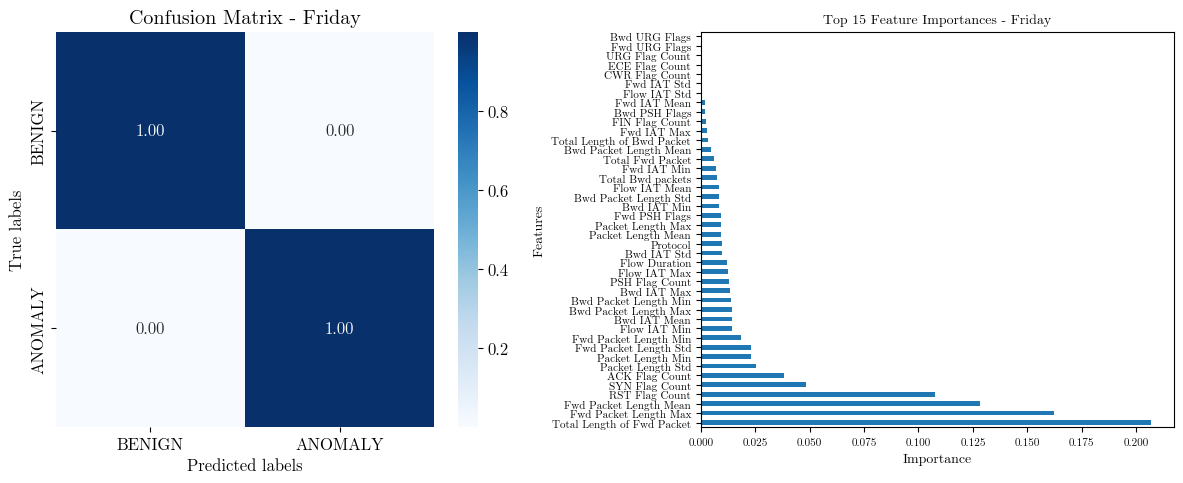

           Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday     1.000000  1.000000  1.000000  1.000000  1.000000
Wednesday   0.999942  0.999806  0.999912  0.999874  0.999887
Thursday    1.000000  0.880597  0.999926  0.936508  0.940299
Friday      0.997586  0.999699  0.998730  0.998641  0.998791


In [4]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set font style using matplotlib
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 12
# plt.rcParams['text.color'] = 'black'

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory
PATH = "datasets"
output_path = PATH + '/no_feat_sel/binary-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Initialize a dictionary to store the metrics for the model
model_metrics = {}
confusion_matrices = {}
feature_importances_dict = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)

    # Preprocessing steps identical to the feature selection stage...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    data['binary_label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    y = data['binary_label']
    
    columns_to_keep = [
    "Protocol",
    "Total Fwd Packet",
    "Total Bwd packets",
    "Total Length of Fwd Packet",
    "Total Length of Bwd Packet",
    "Flow Duration",
    "Packet Length Min",
    "Packet Length Max",
    "Packet Length Mean",
    "Packet Length Std",
    "Fwd Packet Length Max",
    "Fwd Packet Length Min",
    "Fwd Packet Length Mean",
    "Fwd Packet Length Std",
    "Bwd Packet Length Max",
    "Bwd Packet Length Min",
    "Bwd Packet Length Mean",
    "Bwd Packet Length Std",
    "Flow IAT Mean",
    "Flow IAT Std",
    "Flow IAT Max",
    "Flow IAT Min",
    "Fwd IAT Mean",
    "Fwd IAT Std",
    "Fwd IAT Max",
    "Fwd IAT Min",
    "Bwd IAT Mean",
    "Bwd IAT Std",
    "Bwd IAT Max",
    "Bwd IAT Min",
    "FIN Flag Count",
    "SYN Flag Count",
    "RST Flag Count",
    "PSH Flag Count",
    "ACK Flag Count",
    "URG Flag Count",
    "CWR Flag Count",
    "ECE Flag Count",
    "Fwd PSH Flags",
    "Bwd PSH Flags",
    "Fwd URG Flags",
    "Bwd URG Flags"
    ]  
    X = data[columns_to_keep]
        
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
    # Initialize RandomForest Classifier
    model = RandomForestClassifier()
    
    # Train RandomForest Classifier
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute the metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Store metrics
    model_metrics[day] = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Plotting Confusion Matrix and Feature Importances side by side
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    unique_labels = ['BENIGN', 'ANOMALY']
  
    # Store the computed confusion matrix and labels
    confusion_matrices[day] = {
        'matrix': cm.tolist(),  # Convert numpy array to list for JSON serialization
        'labels': unique_labels  # Store the unique labels
    }
    
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=ax[0],
                xticklabels=['BENIGN', 'ANOMALY'], 
                yticklabels=['BENIGN', 'ANOMALY'])
    ax[0].set_title(f'Confusion Matrix - {day}')
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('True labels')

    # Plot Feature Importances
    feature_importances_series = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances_plot = feature_importances_series.nlargest(50).plot(kind='barh', ax=ax[1])
    ax[1].set_title(f'Top 15 Feature Importances - {day}', fontsize=10)  # Title font size
    feature_importances_plot.set_xlabel('Importance', fontsize=10)  # X-axis label font size
    feature_importances_plot.set_ylabel('Features', fontsize=10)  # Y-axis label font size
    feature_importances_plot.tick_params(axis='both', which='major', labelsize=8)  # Tick labels font size

    plt.tight_layout()
    plt.show()

    # Extract Feature Importances
    feature_importances_array = model.feature_importances_
    feature_names = X.columns
    feature_importances_day = dict(zip(feature_names, feature_importances_array))
    feature_importances_day = {k: v for k, v in sorted(feature_importances_day.items(), key=lambda item: item[1], reverse=True)}
    feature_importances_dict[day] = feature_importances_day

    # # Save Confusion Matrix Individually
    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
    #             xticklabels=['BENIGN', 'ANOMALY'], 
    #             yticklabels=['BENIGN', 'ANOMALY'])
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # # plt.title(f'Confusion Matrix - {day}')
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_path, f'{day}_confusion_matrix.png'))
    # plt.close()

    # # Save Feature Importances Individually
    # plt.figure(figsize=(6, 5))
    # feature_importances.nlargest(15).plot(kind='barh')
    # # plt.title(f'Top 15 Feature Importances - {day}')
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_path, f'{day}_feature_importances.png'))
    # plt.close()

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i): model_metrics[i]
                                     for i in model_metrics.keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# Save the confusion matrices with labels to a JSON file
cm_json_path = os.path.join(output_path, 'confusion_matrices.json')
with open(cm_json_path, 'w') as cm_file:
    json.dump(confusion_matrices, cm_file, indent=4)

# Convert the feature importances dictionary to a JSON file
feature_importances_json_path = os.path.join(output_path, 'feature_importances.json')
with open(feature_importances_json_path, 'w') as f:
    json.dump(feature_importances_dict, f, indent=4)

## Multi-class Classification

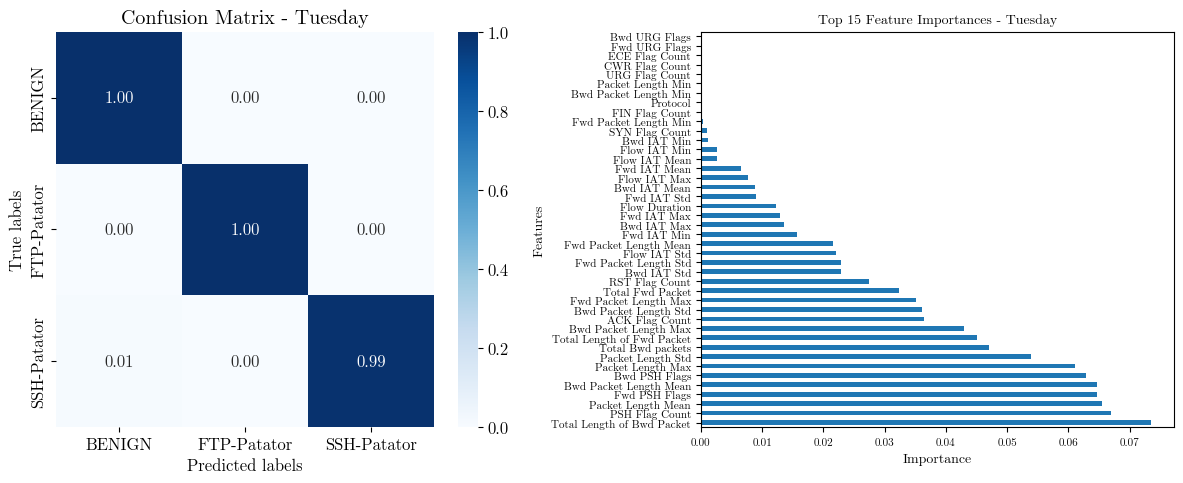

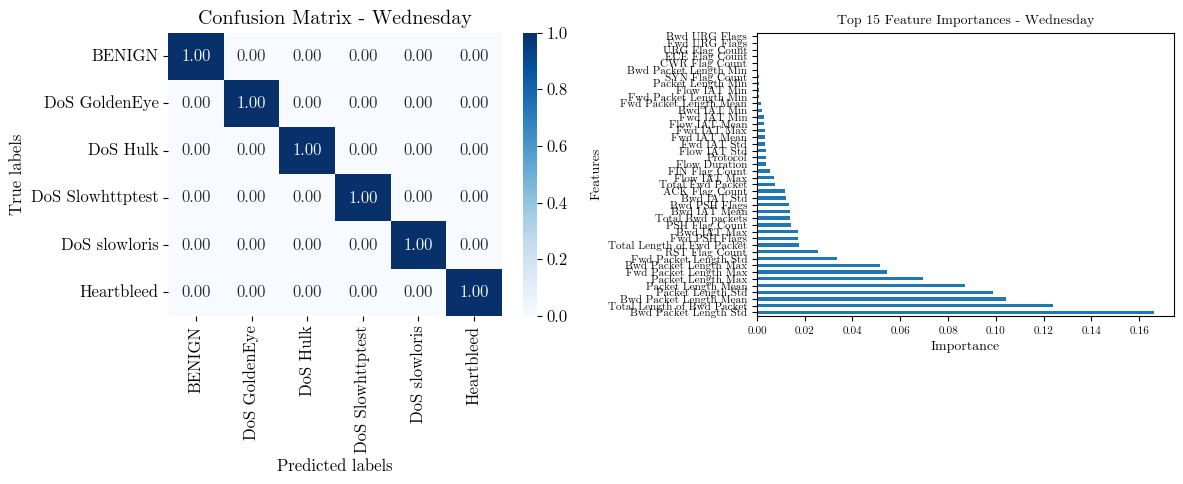

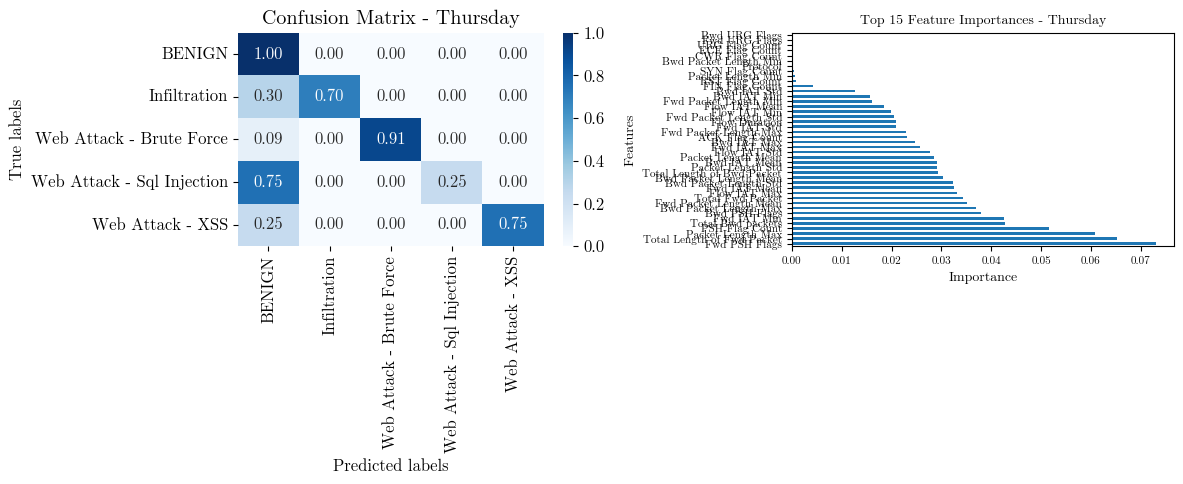

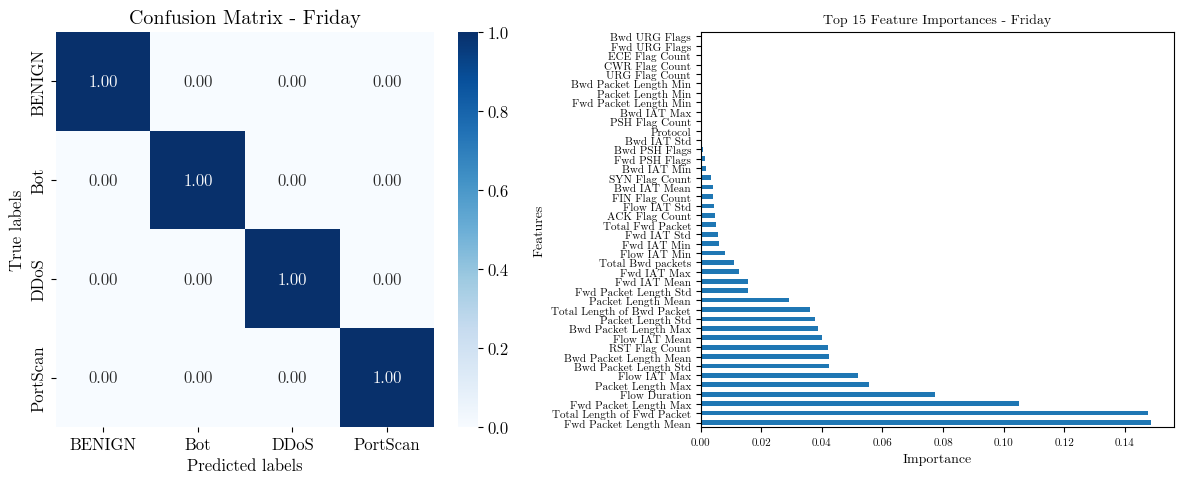

           Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday     0.999928  0.999928  0.999928  0.999927  1.000000
Wednesday   0.999932  0.999932  0.999932  0.999932  0.999997
Thursday    0.999889  0.999889  0.999889  0.999876  0.992481
Friday      0.998747  0.998743  0.998743  0.998743  0.999840


In [5]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set font style using matplotlib
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 12
# plt.rcParams['text.color'] = 'black'

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory
PATH = "datasets"
output_path = PATH + '/no_feat_sel/multi-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Initialize a dictionary to store the metrics for the model
model_metrics = {}
confusion_matrices = {}
feature_importances_dict = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)

    # Preprocessing steps...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    y = data['Label']  # Use original labels for multi-class classification
    
    columns_to_keep = [
    "Protocol",
    "Total Fwd Packet",
    "Total Bwd packets",
    "Total Length of Fwd Packet",
    "Total Length of Bwd Packet",
    "Flow Duration",
    "Packet Length Min",
    "Packet Length Max",
    "Packet Length Mean",
    "Packet Length Std",
    "Fwd Packet Length Max",
    "Fwd Packet Length Min",
    "Fwd Packet Length Mean",
    "Fwd Packet Length Std",
    "Bwd Packet Length Max",
    "Bwd Packet Length Min",
    "Bwd Packet Length Mean",
    "Bwd Packet Length Std",
    "Flow IAT Mean",
    "Flow IAT Std",
    "Flow IAT Max",
    "Flow IAT Min",
    "Fwd IAT Mean",
    "Fwd IAT Std",
    "Fwd IAT Max",
    "Fwd IAT Min",
    "Bwd IAT Mean",
    "Bwd IAT Std",
    "Bwd IAT Max",
    "Bwd IAT Min",
    "FIN Flag Count",
    "SYN Flag Count",
    "RST Flag Count",
    "PSH Flag Count",
    "ACK Flag Count",
    "URG Flag Count",
    "CWR Flag Count",
    "ECE Flag Count",
    "Fwd PSH Flags",
    "Bwd PSH Flags",
    "Fwd URG Flags",
    "Bwd URG Flags"
    ]  
    X = data[columns_to_keep]
        
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
    # Initialize RandomForest Classifier
    model = RandomForestClassifier()
    
    # Train RandomForest Classifier
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute the metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
    
    # Store metrics
    model_metrics[day] = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Plotting Confusion Matrix and Feature Importances side by side
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    unique_labels = sorted(y_test.unique().tolist())  # Extract unique labels from y_test
    # sorted(np.unique(np.concatenate([y_test, y_pred])), key=lambda x: (x not in y_test, x))

    # Store the computed confusion matrix and labels
    confusion_matrices[day] = {
        'matrix': cm.tolist(),  # Convert numpy array to list for JSON serialization
        'labels': unique_labels  # Store the unique labels
    }
    
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=ax[0], xticklabels=np.unique(y), yticklabels=np.unique(y))
    ax[0].set_title(f'Confusion Matrix - {day}')
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('True labels')

    # Plot Feature Importances
    feature_importances_series = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances_plot = feature_importances_series.nlargest(50).plot(kind='barh', ax=ax[1])
    ax[1].set_title(f'Top 15 Feature Importances - {day}', fontsize=10)  # Title font size
    feature_importances_plot.set_xlabel('Importance', fontsize=10)  # X-axis label font size
    feature_importances_plot.set_ylabel('Features', fontsize=10)  # Y-axis label font size
    feature_importances_plot.tick_params(axis='both', which='major', labelsize=8)  # Tick labels font size

    plt.tight_layout()
    plt.show()

    # Extract Feature Importances
    feature_importances_array = model.feature_importances_
    feature_names = X.columns
    feature_importances_day = dict(zip(feature_names, feature_importances_array))
    feature_importances_day = {k: v for k, v in sorted(feature_importances_day.items(), key=lambda item: item[1], reverse=True)}
    feature_importances_dict[day] = feature_importances_day

    # # Save Confusion Matrix Individually
    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # # plt.title(f'Confusion Matrix - {day}')
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_path, f'{day}_confusion_matrix.png'))
    # plt.close()

    # # Save Feature Importances Individually
    # plt.figure(figsize=(6, 5))
    # feature_importances.nlargest(15).plot(kind='barh')
    # # plt.title(f'Top 15 Feature Importances - {day}')
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_path, f'{day}_feature_importances.png'))
    # plt.close()

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i): model_metrics[i]
                                     for i in model_metrics.keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# Save the confusion matrices with labels to a JSON file
cm_json_path = os.path.join(output_path, 'confusion_matrices.json')
with open(cm_json_path, 'w') as cm_file:
    json.dump(confusion_matrices, cm_file, indent=4)

# Convert the feature importances dictionary to a JSON file
feature_importances_json_path = os.path.join(output_path, 'feature_importances.json')
with open(feature_importances_json_path, 'w') as f:
    json.dump(feature_importances_dict, f, indent=4)